In [1]:
#Importing the required libraries

from qutip import *
import numpy as np
from scipy import integrate
from helper_code_qutip import * 
import scipy.io

In [2]:
## Importing the data from the .mat file

matlab_data1 = scipy.io.loadmat('../matlab/data_plotting_vsbeta_1/data_2_4_3.mat',mat_dtype=False)
matlab_data2 = scipy.io.loadmat('../matlab/data_plotting_vsbeta_1/data_2_4_4.mat',mat_dtype=False)  # is set to True, givex complex casting to real errors..

In [3]:
## Processing to see whether the data is extracted correctly or not

betalist1 = matlab_data1['betalist'][0]
betalist2 = matlab_data2['betalist'][0]

gamma_matrices1 = matlab_data1['gamma_matrices'][0]
ls_matrices1 = matlab_data1['lamb_shift_matrices'][0]

gamma_matrices2 = matlab_data2['gamma_matrices'][0]
ls_matrices2 = matlab_data2['lamb_shift_matrices'][0]

NL = int(matlab_data1["NL"][0,0])
NM = int(matlab_data2["NM"][0,0])

print('NL and NM are ', NL, NM, 'respectively')

N = NL + NM
dL = 2**NL
dM = 2**NM
d = 2**N
dims = [2]*N

NL and NM are  2 4 respectively


In [4]:
print(gamma_matrices2.shape)
print(ls_matrices2.shape)

#print(gamma_matrices2[1])
print(betalist1)
print(betalist2)

(15,)
(15,)
[1000.            5.55555556    5.        ]
[1.00000000e+03 1.74716086e+00 8.74344242e-01 5.83066095e-01
 4.37363324e-01 3.49921268e-01 2.91618064e-01 2.49968754e-01
 2.18729494e-01 1.94430942e-01 1.74991250e-01 1.59085486e-01
 1.45830295e-01 1.34614090e-01 1.25000000e-01]


In [5]:
def matrix_transform(gamma_matrix,ls_matrix):
    gamma_matr = np.zeros((dL**2-1,dL**2-1), dtype = complex)
    ls_matr = np.zeros((dL,dL), dtype = complex)

    for i in range(dL**2-1):
        for j in range(dL**2-1):
            gamma_matr[i,j] = gamma_matrix[i,j]

    for i in range(dL):
        for j in range(dL):
            ls_matr[i,j] = ls_matrix[i,j]

    return gamma_matr, ls_matr


fin_gamma_matrices1 = [0]*len(betalist1)
fin_ls_matrices1 = [0]*len(betalist1)

fin_gamma_matrices2 = [0]*len(betalist2)
fin_ls_matrices2 = [0]*len(betalist2)

for i in range(len(betalist1)):
    fin_gamma_matrices1[i], fin_ls_matrices1[i] = matrix_transform(gamma_matrices1[i],ls_matrices1[i])

for i in range(len(betalist2)):
    fin_gamma_matrices2[i], fin_ls_matrices2[i] = matrix_transform(gamma_matrices2[i],ls_matrices2[i])





In [6]:
matlab_data3 = scipy.io.loadmat('../matlab/thermal_data1.mat',mat_dtype=False)  # is set to True, givex complex casting to real errors..
matlab_data4 = scipy.io.loadmat('../matlab/thermal_data3.mat',mat_dtype=False)  # is set to True, givex complex casting to real errors..

In [7]:
matlab_F_list1 = matlab_data3["F"]
F_list1 = []

matlab_F_list2 = matlab_data4["F"]
F_list2 = []


for index in range(2**dL):
    matrix1 = np.asmatrix(matlab_F_list1[0,index])
    matrix2 = np.asmatrix(matlab_F_list2[0,index])

    F_list1.append(Qobj(matrix1))
    F_list2.append(Qobj(matrix2))
    
if not basis_is_orthonormal(F_list1):
    print("WARNING : Basis 1 is NOT orthonormal")

if not basis_is_orthonormal(F_list2):
    print("WARNING : Basis 2 is NOT orthonormal")

F_list1.pop() #removes the last indentity basis ..
print(F_list2[-1]) # should be identity matrix
F_list2.pop()

for index in range(2**dL-1):
    F_list1[index].dims = [dims,dims] # makes sure mutliplication will work and QuTiP wont throw errors. 
    F_list2[index].dims = [dims,dims]

Quantum object: dims=[[64], [64]], shape=(64, 64), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.125 0.    0.    ... 0.    0.    0.   ]
 [0.    0.125 0.    ... 0.    0.    0.   ]
 [0.    0.    0.125 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.125 0.    0.   ]
 [0.    0.    0.    ... 0.    0.125 0.   ]
 [0.    0.    0.    ... 0.    0.    0.125]]


In [8]:
w0list = matlab_data2["w0list"][:,0]
w0list = w0list.astype('float')
print('w0list is ', w0list)

glist = matlab_data1["glist"][:,0]
glist = glist.astype('float')

print('glist is', glist)

H_S = create_hamiltonian2(w0list,glist,N)
eigenenergies, eigenstates = H_S.eigenstates()

w0list is  [1. 1. 1. 1. 1. 1.]
glist is [0.0016 0.0016 0.0016 0.0016 0.0016]


In [9]:
p_c= 1e-2
p_h= 1.1e-3

In [10]:
def steady_state_calc(beta1, beta2, gamma_matrix1, gamma_matrix2, ls_matrix1, ls_matrix2):

    
    [D1,U1] = np.linalg.eigh(gamma_matrix1)
    [D2,U2] = np.linalg.eigh(gamma_matrix2)

    L_list1 = []
    Udagger1 = np.transpose(np.conj(U1))
    L_list2 = []
    Udagger2 = np.transpose(np.conj(U2))

    for j  in range(dL**2-1):
        op1 = 0
        op2 = 0
        for betaindex in range(dL**2-1):    
            op1 = op1+Udagger1[j,betaindex]* F_list1[betaindex]
            op2 = op2+Udagger2[j,betaindex]* F_list2[betaindex]
        L_list1.append(op1)
        L_list2.append(op2)

    tildeL_list1 = []
    tildeL_list2 = []

    for index in range(dL**2-1):
        tildeL_list1.append(np.sqrt(p_c*D1[index])*L_list1[index])
        tildeL_list2.append(np.sqrt(p_h*D2[index])*L_list2[index])

    tildeL_list = []
    for i in tildeL_list1:
        tildeL_list.append(i)

    for i in tildeL_list2:
        tildeL_list.append(i)

    H_LS1 = tensor(Qobj(ls_matrix1),qeye(dM))
    H_LS2 = tensor(qeye(dM),Qobj(ls_matrix2))
    H_LS1.dims = [dims,dims]
    H_LS2.dims = [dims,dims]
    rho_ss = steadystate(H_S + p_c*H_LS1 + p_h*H_LS2, tildeL_list)
    #L_operator = liouvillian(H_S+H_LS1+H_LS2, tildeL_list)

    #L_eigen = L_operator.eigenenergies()

    print("Smallest eigenvalues for Tc = ", 1/beta1, "and Th = ", 1/beta2)

    return rho_ss


In [11]:
rho_fin_arr = []
for i in range(len(betalist1)):
    list1 = []
    for j in range(len(betalist2)):
        rho_fin = steady_state_calc(betalist1[i], betalist2[j], fin_gamma_matrices1[i], fin_gamma_matrices2[j], fin_ls_matrices1[i], fin_ls_matrices2[j])
        list1.append(rho_fin)
    rho_fin_arr.append(list1)

Smallest eigenvalues for Tc =  0.001 and Th =  0.001
Smallest eigenvalues for Tc =  0.001 and Th =  0.5723571428571428
Smallest eigenvalues for Tc =  0.001 and Th =  1.1437142857142855
Smallest eigenvalues for Tc =  0.001 and Th =  1.7150714285714284
Smallest eigenvalues for Tc =  0.001 and Th =  2.286428571428571
Smallest eigenvalues for Tc =  0.001 and Th =  2.857785714285714
Smallest eigenvalues for Tc =  0.001 and Th =  3.429142857142857
Smallest eigenvalues for Tc =  0.001 and Th =  4.0005
Smallest eigenvalues for Tc =  0.001 and Th =  4.571857142857143
Smallest eigenvalues for Tc =  0.001 and Th =  5.143214285714286
Smallest eigenvalues for Tc =  0.001 and Th =  5.714571428571428
Smallest eigenvalues for Tc =  0.001 and Th =  6.285928571428572
Smallest eigenvalues for Tc =  0.001 and Th =  6.857285714285714
Smallest eigenvalues for Tc =  0.001 and Th =  7.428642857142856
Smallest eigenvalues for Tc =  0.001 and Th =  8.0
Smallest eigenvalues for Tc =  0.18 and Th =  0.001
Smalles

In [12]:
rho_fin_arr[0][0]

Quantum object: dims=[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape=(64, 64), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.24182908e-13+0.00000000e+00j  1.27345665e-38-1.57882176e-34j
  -3.14149835e-35+2.61952202e-34j ... -1.17333431e-55+8.68160229e-59j
   7.75228463e-56-4.08753132e-57j  7.94701271e-59+2.19080060e-57j]
 [ 1.27345665e-38+1.57882176e-34j  1.87599968e-13+0.00000000e+00j
  -8.96907433e-29+1.13250698e-15j ...  8.42639727e-45-1.86738323e-40j
   2.47674413e-42-6.92863844e-46j  2.74186119e-55+5.16962390e-58j]
 [-3.14149835e-35-2.61952202e-34j -8.96907433e-29-1.13250698e-15j
   1.89181314e-13+0.00000000e+00j ... -1.94169003e-42-9.85589581e-46j
   1.53078414e-45-1.84768848e-40j -9.69769784e-58+4.40652576e-59j]
 ...
 [-1.17333431e-55-8.68160229e-59j  8.42639727e-45+1.86738323e-40j
  -1.94169003e-42+9.85589581e-46j ...  1.73871783e-11+0.00000000e+00j
  -6.31804965e-16-1.07348818e-13j -7.20939158e-27+5.03341985e-22j]
 [ 7.75228463e-56+4.08753132e-57j  2.47674413e-42+6.92

In [13]:
reduced_dm_list = []

for i in range(len(betalist1)):
    list2 = []
    for j in range(len(betalist2)):
        reduced_dm = ptrace(rho_fin_arr[i][j],[2,3])
        list2.append(reduced_dm)
    reduced_dm_list.append(list2)

In [14]:
def concurrence2(rho):
    if rho.type == 'ket':
        rho = ket2dm(rho)
    if rho.type != 'oper':
        raise TypeError("Input must be a density matrix or ket")
    
    rho_tilde = tensor(sigmay(),sigmay())*(rho.conj())*tensor(sigmay(),sigmay())
    R = (rho.sqrtm()*rho_tilde*rho.sqrtm()).sqrtm()
    evals = R.eigenenergies()
    evals = np.sort(np.real(evals))
    print(evals) #testing
    val = evals[-1] - evals[-2] - evals[-3] - evals[-4]
    return np.max([0,val])

In [15]:
###test concurrence2
test_rho = reduced_dm_list[0][2]

print(test_rho.eigenenergies())

print(concurrence2(test_rho))

[0.01683119 0.06394675 0.06659322 0.85262884]
[0.06394691 0.06659306 0.11979464 0.11979464]
0.0


In [16]:
## Now we can calculate concurrence, purity, etc.

Th_list = np.linspace(0.001,8,15)
Tc_list = [0.001,0.18,0.20]  #Not using values zero exatcly because of numerical issues

g= 1.6e-3  #Using values given in the paper

def concurrence_plot(Th_list,Tc_list,reduced_dm_list):
    for i in range(len(Tc_list)):
        concurrence_list = []
        for j in range(len(Th_list)):
            concurrence_list.append(concurrence(reduced_dm_list[i][j]))
            print(f'Concurrence Qutip for Tc = {Tc_list[i]} and Th = {round(Th_list[j],2)}: ',concurrence(reduced_dm_list[i][j]))
            concurrence2(reduced_dm_list[i][j])
        plt.plot(Th_list,concurrence_list,label='Tc/E = '+str(Tc_list[i]))

    plt.xlabel('Thermal bath temperature (T_h/E)')
    plt.ylabel('Concurrence')
    plt.title(f'Concurrence vs Th for different Tc at g = {g}, pc = {p_c}, ph = {p_h}')
    plt.legend()


Concurrence Qutip for Tc = 0.001 and Th = 0.0:  0
[4.09005961e-11 4.10620146e-11 3.33917425e-06 3.33917425e-06]
Concurrence Qutip for Tc = 0.001 and Th = 0.57:  0
[0.02602592 0.02700035 0.07528821 0.07528821]
Concurrence Qutip for Tc = 0.001 and Th = 1.14:  0
[0.06394691 0.06659306 0.11979464 0.11979464]
Concurrence Qutip for Tc = 0.001 and Th = 1.72:  0
[0.08052778 0.0840519  0.1359089  0.1359089 ]
Concurrence Qutip for Tc = 0.001 and Th = 2.29:  0
[0.08710233 0.09101662 0.1422281  0.1422281 ]
Concurrence Qutip for Tc = 0.001 and Th = 2.86:  0
[0.09111249 0.09527493 0.14601065 0.14601065]
Concurrence Qutip for Tc = 0.001 and Th = 3.43:  0
[0.09342769 0.09773942 0.1482166  0.1482166 ]
Concurrence Qutip for Tc = 0.001 and Th = 4.0:  0
[0.09522895 0.09965774 0.14990138 0.14990138]
Concurrence Qutip for Tc = 0.001 and Th = 4.57:  0
[0.09648197 0.10099387 0.15107988 0.15107988]
Concurrence Qutip for Tc = 0.001 and Th = 5.14:  0
[0.09745076 0.10202756 0.15198863 0.15198863]
Concurrence Quti

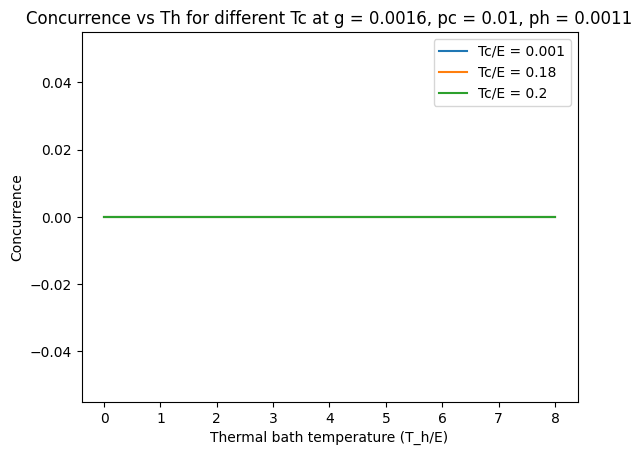

In [17]:
concurrence_plot(Th_list,Tc_list,reduced_dm_list)

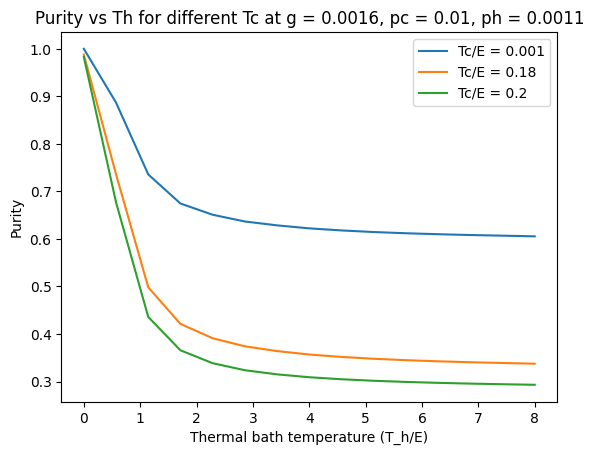

In [33]:
def purity_plot(Th_list,Tc_list,reduced_dm_list):
    for i in range(len(Tc_list)):
        purity_list = []
        for j in range(len(Th_list)):
            purity_list.append(reduced_dm_list[i][j].purity())
        plt.plot(Th_list,purity_list,label='Tc/E = '+str(Tc_list[i]))

    plt.xlabel('Thermal bath temperature (T_h/E)')
    plt.ylabel('Purity')
    plt.title(f'Purity vs Th for different Tc at g = {g}, pc = {p_c}, ph = {p_h}')
    plt.legend()

purity_plot(Th_list,Tc_list,reduced_dm_list)

In [35]:
def thermal_c(E,T_c):
    r_c = 1/(1+np.exp(-E/T_c))
    t_c = r_c*fock_dm(2,1) + (1-r_c)*fock_dm(2,0)

    return t_c

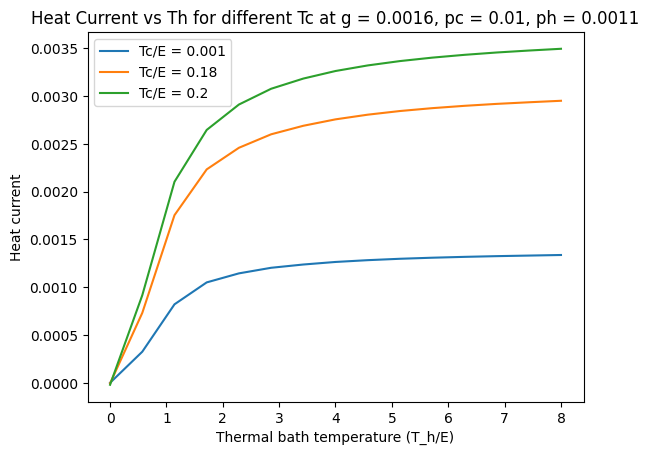

In [36]:
def heat_current(Th_list,Tc_list,reduced_dm_list):
    for i in range(len(Tc_list)):
        heat_curr_list = []
        for j in range(len(Th_list)):
            ss = reduced_dm_list[i][j]
            rho_c = ss.ptrace(0)
            thermal_cold = thermal_c(1.0,Tc_list[i])

            heat_curr = p_c*(fock(2,0).dag()*(rho_c - thermal_cold)*fock(2,0))  #as |0> is the excited state

            heat_curr_list.append(heat_curr.real)
        plt.plot(Th_list,heat_curr_list,label='Tc/E = '+str(Tc_list[i]))
    
    plt.xlabel('Thermal bath temperature (T_h/E)')
    plt.ylabel('Heat current')
    plt.title(f'Heat Current vs Th for different Tc at g = {g}, pc = {p_c}, ph = {p_h}')
    plt.legend()

heat_current(Th_list,Tc_list,reduced_dm_list)

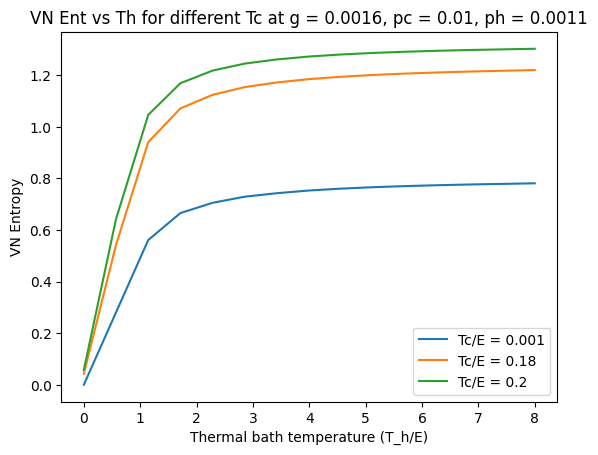

In [37]:
def vn_plot(Th_list,Tc_list,reduced_dm_list):
    for i in range(len(Tc_list)):
        concurrence_list = []
        for j in range(len(Th_list)):
            concurrence_list.append(entropy_vn(reduced_dm_list[i][j]))
        plt.plot(Th_list,concurrence_list,label='Tc/E = '+str(Tc_list[i]))

    plt.xlabel('Thermal bath temperature (T_h/E)')
    plt.ylabel('VN Entropy')
    plt.title(f'VN Ent vs Th for different Tc at g = {g}, pc = {p_c}, ph = {p_h}')
    plt.legend()

vn_plot(Th_list,Tc_list,reduced_dm_list)

In [18]:
## Let us also calculate negativity

def negativity(rho):
    rho_pt1 = partial_transpose(rho,[1,0])
    rho_pt2 = partial_transpose(rho,[0,1])

    neg1 = 0.5*(rho_pt1.norm()-1)
    neg2 = 0.5*(rho_pt2.norm()-1)

    return (neg1,neg2)




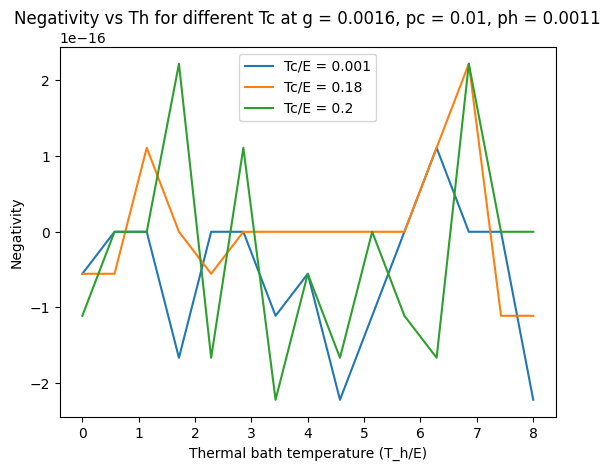

In [20]:
def neg_plot(Th_list,Tc_list,reduced_dm_list):
    for i in range(len(Tc_list)):
        neg_list1 = []
        neg_list2 = []
        for j in range(len(Th_list)):
            neg1,neg2 = negativity(reduced_dm_list[i][j])
            neg_list1.append(neg1)
            neg_list2.append(neg2)
        plt.plot(Th_list,neg_list1,'-',label='Tc/E = '+str(Tc_list[i]))
        #plt.plot(Th_list,neg_list1,'--',label='Tc/E = '+str(Tc_list[i]))

    plt.xlabel('Thermal bath temperature (T_h/E)')
    plt.ylabel('Negativity')
    plt.title(f'Negativity vs Th for different Tc at g = {g}, pc = {p_c}, ph = {p_h}')
    plt.legend()

neg_plot(Th_list,Tc_list,reduced_dm_list)

## Based on Concurrence and negativity, it seems that there is no Entanglement in this scenario

In [24]:
print(reduced_dm_list[0][1].eigenenergies())

[0.00602404 0.02602584 0.02700044 0.94094969]
